In [1]:
import pandas as pd
import os
import tqdm
import numpy as np
import pprint
import pickle

# Load Data

In [2]:
def icd2dict(icd):
    i, c, d = icd.split(':')
    return {'itemID': i, 'clicked': bool(eval(c)), 'duration': eval(d)}
class Sequence:
    def __init__(self, sequence):
        """
        :param sequence: {str}, e.g. '133679233276:0:0;133658338671:0:0;133677846615:0:0'
        :return:
        """
        self.sequence = [icd2dict(icd) for icd in sequence.split(';')]
        self.length = len(self.sequence)
        self.clicked = sum([_['clicked'] for _ in self.sequence])
        self.duration = sum([_['duration'] for _ in self.sequence])
    def myprint(self):
        pprint.pprint(self.sequence)
        print('length:', self.length)
        print('clicked:', self.clicked)
        print('duration:', self.duration)

In [3]:
data_path = 'mathorcup_recom_listwise/data/'

In [4]:
if not os.path.exists(data_path + 'userID2idx.pickle'):
    train_df = pd.read_csv(data_path + 'train_data.csv', dtype=str)
    train_userID = set(train_df.loc[:, 'userID'])
    userID2idx = {_: str(i).zfill(7) for i, _ in enumerate(train_userID)}
    with open(data_path + 'userID2idx.pickle', 'wb') as handle:
        pickle.dump(userID2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(data_path + 'userID2idx.pickle', 'rb') as handle:
    userID2idx = pickle.load(handle)

In [5]:
with open(data_path + 'contentTC2ID.pickle', 'rb') as handle:
    contentTC2ID = pickle.load(handle)
with open(data_path + 'contentID2idx.pickle', 'rb') as handle:
    contentID2idx = pickle.load(handle)
with open(data_path + 'key2idx.pickle', 'rb') as handle:
    key2idx = pickle.load(handle)

In [6]:
if not os.path.exists(data_path + 'idx2key.pickle'):
    idx2key = dict()
    for k, v in tqdm.tqdm(key2idx.items()):
        idx2key[v] = k
    with open(data_path + 'idx2key.pickle', 'wb') as handle:
        pickle.dump(idx2key, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(data_path + 'idx2key.pickle', 'rb') as handle:
    idx2key = pickle.load(handle)

In [7]:
len(contentTC2ID)

1485

# Small Test

In [8]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
%matplotlib inline

## Train User Statistics

In [9]:
#userID = '1015554520'
#idx = '0000335'
userID = '1091839846'
idx = '0000062'
aaa, bb, cc = idx[0:3], idx[3:5], idx[5:7]
df = pd.read_csv('data_splitted_by_user_id/{}/{}/{}.csv'.format(aaa, bb, cc), dtype=str)

clickeds = np.zeros(len(contentTC2ID))
durations = np.zeros(len(contentTC2ID))
recommeds = np.zeros(len(contentTC2ID))

for s in df.sequence:
    for icd in s.split(';'):
        i, c, d = icd.split(':')
        contentIdx = contentID2idx[i]
        if eval(c):
            clickeds[contentIdx] += 1
            durations[contentIdx] += eval(d)
        recommeds[contentIdx] += 1


[How to return 0 with divide by zero](https://stackoverflow.com/a/37977222/12224183)

> ```python
c = np.divide(a, b, out=np.zeros_like(a), where=b!=0)
```

In [12]:
avg_clicked_rate = np.divide(clickeds, recommeds, out=np.zeros_like(clickeds), where=recommeds!=0)
avg_clicked_duration = np.divide(durations, clickeds, out=np.zeros_like(durations), where=clickeds!=0)

[Find largest index of nonzero in python](https://stackoverflow.com/a/25512679/12224183)
```python
import numpy as np
y = [0, 0, 2, 3, 1, 0, 0, 3, 0]
print np.where(y)[0].max()
```

[Matplotlib Xticks Values in Bar Chart](https://stackoverflow.com/a/47893553/12224183)

```python
idx = np.asarray([i for i in range(len(years))])
width = 0.2
ax.bar(idx, [val for key,val in sorted(diabete.items())], width=width)
ax.bar(idx+width, [val for key,val in sorted(not_diabete.items())], width=width)
ax.set_xticks(idx)
ax.set_xticklabels(years, rotation=65)
```

[Secondary axis with twinx(): how to add to legend?]https://stackoverflow.com/a/10129461/12224183)

```python
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
```

[How to plot a figure with Chinese Characters in label](https://stackoverflow.com/a/39655334/12224183)

```python
fontP = font_manager.FontProperties()
fontP.set_family('SimHei')
fontP.set_size(14)
```

[How to make matplotlib display Chinese correctly](https://stackoverflow.com/a/66526050/12224183)

```python
from matplotlib import font_manager
my_font = font_manager.FontProperties(fname="./NotoSerifCJK-Bold.ttc")
plt.xticks(range(len(districts)),districts,fontproperties=my_font)
```

[Plt.show shows full graph but savefig is cropping the image](https://stackoverflow.com/a/37428142/12224183)

```python
plt.savefig('X:/' + newName + '.png', bbox_inches='tight')
```

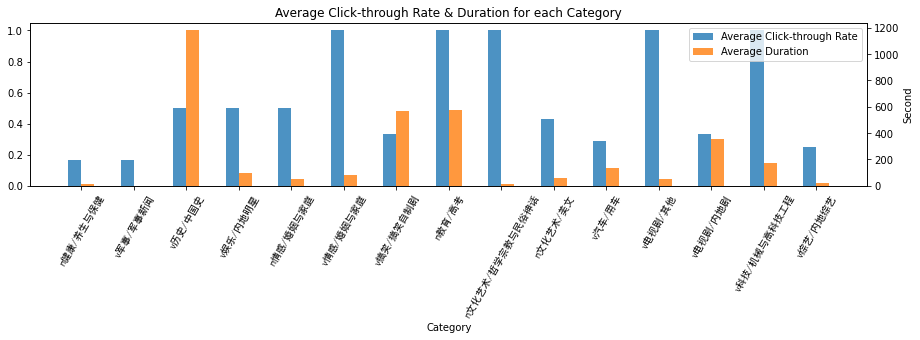

In [18]:
title = 'Average Click-through Rate & Duration for each Category'
width = 0.25
alpha = 0.8
fontP = font_manager.FontProperties()
fontP.set_family('SimHei')
#fontP.set_size(11)

fig, ax = plt.subplots(figsize=(15,3))
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
plt.title(title)

xticklabels = [idx2key[_] for _ in np.arange(len(contentTC2ID))[np.where(avg_clicked_rate != 0)]]
ax.set_xticks(range(len(xticklabels)))
ax.set_xticklabels(xticklabels, fontproperties=fontP, rotation=60)

bar1 = ax.bar(
    np.arange(len(xticklabels)) - width / 2, 
    avg_clicked_rate[np.where(avg_clicked_rate != 0)], 
    color='tab:blue', 
    width=width, 
    alpha=alpha,
    label='Average Click-through Rate'
)
ax.set_xlabel('Category')
# ax.set_yscale('log')

bar2 = ax2.bar(
    np.arange(len(xticklabels)) + width / 2, 
    avg_clicked_duration[np.where(avg_clicked_rate != 0)], 
    color='tab:orange', 
    width=width,
    alpha=alpha,
    label='Average Duration'
)
ax2.set_ylabel('Second')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.savefig('images/{}.png'.format(title), bbox_inches='tight')

## Start Prediction

In [45]:
test_sequence = df.loc[2, 'sequence']
test_sequence

'133675372129:0:0;133672702112:1:31;506721457:0:0;506721457:1:269;506724337:1:36;506724337:1:149;506724337:1:30;506360020:0:0;506360020:1:226;506648067:1:114;506648067:0:0;133675375066:0:0'

In [46]:
recommeds = np.zeros(len(contentTC2ID))
clickeds_label = np.zeros(len(contentTC2ID))  # useless in test
durations_label = np.zeros(len(contentTC2ID))  # useless in test
for icd in test_sequence.split(';'):
    i, c, d = icd.split(':')
    recommeds[contentID2idx[i]] += 1
    
    if eval(c):  # useless in test
        clickeds_label[contentIdx] += 1
        durations_label[contentIdx] += eval(d)

[How to get element-wise matrix multiplication (Hadamard product) in numpy?](https://stackoverflow.com/a/40035266/12224183)

> ```python
import numpy as np
a = np.array([[1,2],[3,4]])
b = np.array([[5,6],[7,8]])
np.multiply(a,b)
```

## Clicked Prediction

In [47]:
sum(clickeds_label)  # true

7.0

In [48]:
np.inner(recommeds, avg_clicked_rate)

7.326298701298701

## Duration Prediction

In [49]:
sum(durations_label)  # true

855.0

In [50]:
np.inner(recommeds, np.multiply(avg_clicked_rate, avg_clicked_duration))

734.1672077922078